### Preliminary setup

This notebook will use R, users will need to ensure an R jupyter interface such as *rpy2* is installed for this to work properly. If you need to install this interface: 

In [15]:
%%bash
pip3 install rpy2

And then to tell this jupyter notebook to use this R interface, following command blocks will have a %% prepended specifying if this should be run with bash or R

In [1]:
%load_ext rpy2.ipython

### VEP (Variant Effect Predictor) - Cache Installation

The first step to using the variant is to install a Cache, **most users will not have to bother with this**, if you are fine with using the cache and VEP versions already downloaded to storage1/compute1 you can ignore this. Inncidently the Cache already on storage1 is at `/storage1/fs1/bga/Active/gmsroot/gc2560/core/cwl/inputs/VEP_cache`

If however you need a species, assembly, or vep version not supported by the support infrastructure you will need to install one yourself

As a bit of a tangent, you can run VEP in "online" mode, meaning that VEP will hit ensembl servers instead of a local cache, however I don't recommend this. It will be extremely slow.

To Start I SSH into compute1 (my ssh keys for compute1 are named after marine mammals, so yours will be different)

From there I get into an interactive VEP session and run the INSTALL.pl perl script for VEP located in /opt/vep/src

Now let's talk about some of the parameters, the big one is -c, it tells the installer where to download the cache, I use -a to specify what i want installed, which for pretty much everyone would be the fasta file and the cache itself denoted by f and c respectively. -s informs VEP I want this for the canis_lupus_familiaris species, -l and --NO_BIOPERL are skipping additional specific packages that are not needed (and are a pain to get installed). And finnally I say I want the CanFam3.1 reference assembly.

All of this typically takes a couple hours so be prepared to wait (which is also why i have this commented out).

As a side note, you were to run without the -a parameter you would be walked through by the installer what you wanted to install. This might be more convinient for some users.



In [19]:
%%bash
ssh beluga
LSF_DOCKER_PRESERVE_ENVIRONMENT=false bsub -M 8000000 -R 'select[mem>8000] span[hosts=1] rusage[mem=8000]' -n 8 -G compute-obigriffith -Is -a 'docker(ensemblorg/ensembl-vep:release_101.0)' /bin/bash
perl /opt/vep/src/ensembl-vep/INSTALL.pl --help
#perl /opt/vep/src/ensembl-vep/INSTALL.pl -c /storage1/fs1/obigriffith/Active/common/vepCache/ -a fc -s canis_lupus_familiaris -l --NO_BIOPERL --ASSEMBLY CanFam3.1
exit

Job <456732> is submitted to default queue <general-interactive>.
release_101.0: Pulling from ensemblorg/ensembl-vep
f08d8e2a3ba1: Pulling fs layer
3baa9cb2483b: Pulling fs layer
94e5ff4c0b15: Pulling fs layer
1860925334f9: Pulling fs layer
59ea04b4d1f5: Pulling fs layer
35da7fd97b95: Pulling fs layer
71bb648dfd3b: Pulling fs layer
3f8d7e441f68: Pulling fs layer
d23ab4039a95: Pulling fs layer
72cd523e7fc6: Pulling fs layer
0f0efd126ff4: Pulling fs layer
59ea04b4d1f5: Waiting
0f0efd126ff4: Waiting
d23ab4039a95: Waiting
3f8d7e441f68: Waiting
35da7fd97b95: Waiting
3baa9cb2483b: Verifying Checksum
3baa9cb2483b: Download complete
94e5ff4c0b15: Verifying Checksum
94e5ff4c0b15: Download complete
f08d8e2a3ba1: Download complete
1860925334f9: Download complete
35da7fd97b95: Verifying Checksum
35da7fd97b95: Download complete
3f8d7e441f68: Download complete
59ea04b4d1f5: Verifying Checksum
59ea04b4d1f5: Download complete
d23ab4039a95: Verifying Checksum
d23ab4039a95: Download complete
71bb648dfd3

Pseudo-terminal will not be allocated because stdin is not a terminal.
You are connecting to RIS Compute services.
Membership in a compute-* AD group is required.

Users are responsible for acting in accordance with
policies applicable to Washington University St. Louis.

https://confluence.ris.wustl.edu/display/RSUM/RIS+Compute+%3A+User+Agreement
<<Waiting for dispatch ...>>
<<Starting on compute1-exec-162.ris.wustl.edu>>


### Uploading Preliminary Data for VEP

Now on to the fun stuff, actually annotated our data with usefull information. For this we'll use a copy of the data from last week available in this repo and push it up to our home directory. We can use `scp` for this, as a reminder your ssh keys are likely different than mine.

In [2]:
%%bash
cd ~/git/bfx-workshop/week_10
scp mutect.filtered.decomposed.readcount_snvs_indel.vcf.gz beluga:~

You are connecting to RIS Compute services.
Membership in a compute-* AD group is required.

Users are responsible for acting in accordance with
policies applicable to Washington University St. Louis.

https://confluence.ris.wustl.edu/display/RSUM/RIS+Compute+%3A+User+Agreement


### Running VEP
Next we'll actually run VEP on our VCF file, see below for a description of some of the parameters

In [3]:
%%bash
ssh beluga

LSF_DOCKER_VOLUMES=/storage1/fs1/bga/Active:/storage1/fs1/bga/Active LSF_DOCKER_PRESERVE_ENVIRONMENT=false bsub -oo vep.log -q general -M 8000000 -R 'select[mem>8000] span[hosts=1] rusage[mem=8000]' -n 8 -G compute-oncology -a 'docker(ensemblorg/ensembl-vep:release_101.0)' /opt/vep/src/ensembl-vep/vep --cache --dir_cache=/storage1/fs1/bga/Active/gmsroot/gc2560/core/cwl/inputs/VEP_cache/ --input_file=mutect.filtered.decomposed.readcount_snvs_indel.vcf.gz --output_file=mutect.filtered.decomposed.readcount_snvs_indel.flag_pick.vcf --everything --fasta=/storage1/fs1/bga/Active/gmsroot/gc2560/core/cwl/inputs/VEP_cache/homo_sapiens/101_GRCh38/Homo_sapiens.GRCh38.dna.toplevel.fa.gz --force_overwrite --vcf --terms SO --assembly=GRCh38 --offline --pick --force_overwrite --no_check_variants_order --fork 4 --transcript_version

LSF_DOCKER_VOLUMES=/storage1/fs1/bga/Active:/storage1/fs1/bga/Active LSF_DOCKER_PRESERVE_ENVIRONMENT=false bsub -oo vep_nopick.log -q general -M 8000000 -R 'select[mem>8000] span[hosts=1] rusage[mem=8000]' -n 8 -G compute-oncology -a 'docker(ensemblorg/ensembl-vep:release_101.0)' /opt/vep/src/ensembl-vep/vep --cache --dir_cache=/storage1/fs1/bga/Active/gmsroot/gc2560/core/cwl/inputs/VEP_cache/ --input_file=mutect.filtered.decomposed.readcount_snvs_indel.vcf.gz --output_file=mutect.filtered.decomposed.readcount_snvs_indel.no_pick.vcf --everything --fasta=/storage1/fs1/bga/Active/gmsroot/gc2560/core/cwl/inputs/VEP_cache/homo_sapiens/101_GRCh38/Homo_sapiens.GRCh38.dna.toplevel.fa.gz --force_overwrite --vcf --terms SO --assembly=GRCh38 --offline --force_overwrite --no_check_variants_order --fork 4 --transcript_version

Job <465319> is submitted to queue <general>.
Job <465320> is submitted to queue <general>.


Pseudo-terminal will not be allocated because stdin is not a terminal.
You are connecting to RIS Compute services.
Membership in a compute-* AD group is required.

Users are responsible for acting in accordance with
policies applicable to Washington University St. Louis.

https://confluence.ris.wustl.edu/display/RSUM/RIS+Compute+%3A+User+Agreement


While we're waiting for that job to complete let's talk about some of the options we specified that aren't so obvious, first as mentioned previously we need to supply the path to an appropriate VEP cache where annotations can be pulled.

the --everything flag tells vep to annotate a fairly comprehensive set of items including transcript support level in ensembl, the hgvs notations, gene symbols etc.

the --vcf flag tells VEP to output in VCF format

--force_overwrite, will overwrite VEP results if they're present in the directory (this is especially usefull if you decide you want more annotations and don't want to remove files to re-run VEP)

--terms SO tells VEP to use the sequence ontology to annotate variant consequences i.e. stop_gain, frameshift, etc.

--no_check_variants_order means that VEP will be able to run on unsorted input files (though this comes at a significant computational cost)

--fork is the multi-threading parameter, this will drastically speed up thee runtime

and Finally --pick tells VEP to output only 1 entry for a variant, for example you could have a variant that is both a missense variant in one gene and upstream for another gene, using this option VEP will output the most sever consequence, in this case missense

This just scratches the surface of options available for VEP, but is typically what I run as a "default" and is probably a good place to start. For a more complete list of params there is extensive documentation from ensembl available here: https://uswest.ensembl.org/info/docs/tools/vep/script/vep_options.html#basic

I would like to note that many of VEPs defaults are designed around h.sapiens, for example it is quite simple to run on a different species however you will need that species in your cache and you will need to specify the desired species with the --species parameter


### Downloading and viewing VEP results

VEP outputs a number of files of potential interest, including an HTML report, the file you really probably care about though is the VCF file we had VEP output in the command above, lets go ahead and pull it down and take a look, here I use grep to print the surrounding lines around the pattern match. Importantly we see that for each variant our annotation info is specified under the "INFO" column and  the "INFO" meta line in the header tells us what each column represents in the | delimited VCF file. unfortunately this is quite hard to parse, so we will use R to extract some of this information and have a short plotting lesson in this tutorial.

In [4]:
%%bash
cd ~/git/bfx-workshop/week_10

scp beluga:~/mutect.filtered.decomposed.readcount_snvs_indel.flag_pick.vcf ./
scp beluga:~/mutect.filtered.decomposed.readcount_snvs_indel.no_pick.vcf ./
    
grep -A 4 -B 2 "#CHROM" mutect.filtered.decomposed.readcount_snvs_indel.flag_pick.vcf

##VEP="v101" time="2020-11-22 04:18:21" cache="/storage1/fs1/bga/Active/gmsroot/gc2560/core/cwl/inputs/VEP_cache/homo_sapiens/101_GRCh38" ensembl-funcgen=101.b918a49 ensembl=101.856c8e8 ensembl-variation=101.50e7372 ensembl-io=101.943b6c2 1000genomes="phase3" COSMIC="90" ClinVar="202003" ESP="V2-SSA137" HGMD-PUBLIC="20194" assembly="GRCh38.p13" dbSNP="153" gencode="GENCODE 35" genebuild="2014-07" gnomAD="r2.1" polyphen="2.2.2" regbuild="1.0" sift="sift5.2.2"
##INFO=<ID=CSQ,Number=.,Type=String,Description="Consequence annotations from Ensembl VEP. Format: Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|VARIANT_CLASS|SYMBOL_SOURCE|HGNC_ID|CANONICAL|MANE|TSL|APPRIS|CCDS|ENSP|SWISSPROT|TREMBL|UNIPARC|GENE_PHENO|SIFT|PolyPhen|DOMAINS|miRNA|HGVS_OFFSET|AF|AFR_AF|AMR_AF|EAS_AF|EUR_AF|SAS_AF|AA_AF|EA_AF|gnomAD_AF|gnomAD_AFR_AF|gnomAD_AMR_AF|gnomAD_

You are connecting to RIS Compute services.
Membership in a compute-* AD group is required.

Users are responsible for acting in accordance with
policies applicable to Washington University St. Louis.

https://confluence.ris.wustl.edu/display/RSUM/RIS+Compute+%3A+User+Agreement
You are connecting to RIS Compute services.
Membership in a compute-* AD group is required.

Users are responsible for acting in accordance with
policies applicable to Washington University St. Louis.

https://confluence.ris.wustl.edu/display/RSUM/RIS+Compute+%3A+User+Agreement


Lets also take a quick look at the difference running VEP with `--pick` made.

In [9]:
%%bash

cat mutect.filtered.decomposed.readcount_snvs_indel.flag_pick.vcf | grep -v "#" | wc -l
cat mutect.filtered.decomposed.readcount_snvs_indel.no_pick.vcf | grep -v "#" | wc -l

echo "pick"
grep "chr17\t5583383" mutect.filtered.decomposed.readcount_snvs_indel.flag_pick.vcf
echo "no pick"
grep "chr17\t5583383" mutect.filtered.decomposed.readcount_snvs_indel.no_pick.vcf

     792
     792
pick
chr17	5583383	.	G	T	.	weak_evidence	AS_FilterStatus=weak_evidence;AS_SB_TABLE=19%2C0|2%2C0;DP=21;ECNT=1;GERMQ=44;MBQ=30,30;MFRL=0,0;MMQ=60,60;MPOS=4;NALOD=1.0;NLOD=2.71;POPAF=6.0;TLOD=4.02;CSQ=T|intron_variant|MODIFIER|NLRP1|ENSG00000091592|Transcript|ENST00000572272.6|protein_coding||1/16|ENST00000572272.6:c.271+304C>A|||||||||-1||SNV|HGNC|HGNC:14374|YES|NM_033004.4|1|P1|CCDS42246.1|ENSP00000460475|Q9C000||UPI0000038309|1||||||||||||||||||||||||||||||||||	GT:AD:AF:DP:F1R2:F2R1:SB	0/0:9,0:0.091:9:0,0:9,0:9,0,0,0	0/1:0,0:0.0:0:0,0:10,2:10,0,2,0
no pick
chr17	5583383	.	G	T	.	weak_evidence	AS_FilterStatus=weak_evidence;AS_SB_TABLE=19%2C0|2%2C0;DP=21;ECNT=1;GERMQ=44;MBQ=30,30;MFRL=0,0;MMQ=60,60;MPOS=4;NALOD=1.0;NLOD=2.71;POPAF=6.0;TLOD=4.02;CSQ=T|intron_variant|MODIFIER|NLRP1|ENSG00000091592|Transcript|ENST00000262467.10|protein_coding||1/15|ENST00000262467.10:c.271+304C>A|||||||||-1||SNV|HGNC|HGNC:14374|||5||CCDS32537.1|ENSP00000262467|Q9C000||UPI00005B2E06|1|||||||

As we can see, with without the `--pick` flag we get far more results/consequences for a specific variant. Though these results are added on a single line, a nuiance of outputting in VCF format. I generally always run with `--pick` but there could be situations in where you would want more thourough results.

### Data Cleanup Pre-amble
Now that we have our annotated VCF data we can start working with it, but first let's clean it up some. As I meentioned above the VEP annotations are there, but are in a "|" delimited string within the Info column. Here we'll parse that info out into a more easily digestable format using R. But first we'll need to install and load a couple libraries we'll be using later on.

I'll note here that I prefer to use the data.table package for data-munging and ggplot2 for plotting. This is mostly personal preference based on the available features within these packages that i've discussed in previous semesters however the R ecosystem is continually being improved and the differences between these libraries and other alternatives are becoming less pronounced. Rather than discuss the pros and cons of these libraries I'll just mention a couple "common" ones if you're looking for alternatives

#### Data Munging
- data.table
- dplyr (part of the tidyverse)
- base R (The Recent release of R 4.0 has made data.frames from base R much more effecient in terms of resources)

#### Ploting
- ggplot2 (probably the clear winner, but theres a learning curve)
- lattice (to each his own, wins in a couple categories like faceting)
- base R (little learning curver here, but not very impressive visually without alot of work)

In [2]:
%%R
#install.packages(c("data.table", "ggplot2"))
library(data.table)
library(ggplot2)

R[write to console]: data.table 1.13.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: **********
This installation of data.table has not detected OpenMP support. It should still work but in single-threaded mode.
This is a Mac. Please read https://mac.r-project.org/openmp/. Please engage with Apple and ask them for support. Check r-datatable.com for updates, and our Mac instructions here: https://github.com/Rdatatable/data.table/wiki/Installation. After several years of many reports of installation problems on Mac, it's time to gingerly point out that there have been no similar problems on Windows or Linux.
**********



### Reading in data
Here we read in the VCF file, theres nothing to special here, but notice the **skip** parameter. This is essentially telling R to not read in anything until it sees this character string, which inncidently is the header row of our VCF file. Basically we are telling R to skip reading in all the meta-info fields at the top of the VCF.

In [3]:
%%R
vcfData <- fread("mutect.filtered.decomposed.readcount_snvs_indel.flag_pick.vcf", skip="#CHROM")

### Parsing out the VEP fields
This bit requires a bit more explanation. Our VEP annotation data is within the INFO column, but thats not the only thing in there, theres additional information that the meta information in the VCF header specifies. Fortunately for us all of our VEP data starts with CSQ, so as a first step we take the INFO column and do a substitution using capture groups replacing the entire INFO string with just the VEP portion of it.

Next we use the tstrsplit() function to split our new "info_vep_only" column we created in the previous step on the "|" field delimiter. The fixed parameter just means to search for a fixed string instead of a regular expression which serves two purposes. The first is that not using a regular expression engine is much faster, secondly "|" have special meanings in regex engines and so we don't have to worry about escaping the pipe if we just tell the function to treat the "|" as a character. This will return a transposed matrix of our VEP data.

Last we can do a simple column-bind (cbind()) binding together our original VCF data with the split out matrix of VEP fields.

In [4]:
%%R
vepAnnotations <- vcfData[,"info_vep_only" := gsub(".*(CSQ=.*)", "\\1", INFO)]
vepAnnotations <- vcfData[,tstrsplit(info_vep_only, split="|", fixed=T)]
vcfData <- cbind(vcfData, vepAnnotations)
vcfData

     #CHROM      POS ID   REF ALT QUAL                                 FILTER
  1:  chr17   445794  .    TA   T    . normal_artifact;slippage;weak_evidence
  2:  chr17   519444  .     G   T    .                          weak_evidence
  3:  chr17   823429  .     G   T    .                          weak_evidence
  4:  chr17   826161  .     G   T    .                                   PASS
  5:  chr17  1484040  .    CA   C    .                 slippage;weak_evidence
 ---                                                                         
788:  chr17 82480287  . GCGCA   G    .                          weak_evidence
789:  chr17 82482039  .     C   A    .                          weak_evidence
790:  chr17 82604724  .     G   T    .                          weak_evidence
791:  chr17 82797739  .    CT   C    .                               slippage
792:  chr17 82801790  .     C   A    .                          weak_evidence
                                                                

791: GT:AD:AF:DP:F1R2:F2R1:SB   0/0:35,1:0.049:36:3,0:30,1:30,5,1,0
792: GT:AD:AF:DP:F1R2:F2R1:SB       0/0:9,0:0.091:9:5,0:4,0:4,5,0,0
                           Exome_Tumor
  1:     0/1:0,0:0:0:5,1:62,4:63,6,4,1
  2:     0/1:0,0:0.0:0:9,2:0,0:0,9,0,2
  3:   0/1:0,0:0.0:0:0,0:22,2:22,0,2,0
  4: 0/1:0,0:0.0:0:30,3:15,0:16,30,0,3
  5:    0/1:0,0:0:0:6,1:21,3:21,12,3,1
 ---                                  
788:     0/1:0,0:0:0:0,0:22,2:25,0,2,0
789:   0/1:0,0:0.0:0:21,2:0,0:0,21,0,2
790:   0/1:0,0:0.0:0:17,2:0,0:0,17,0,2
791:    0/1:0,0:0:0:6,1:41,7:41,13,7,1
792:     0/1:0,0:0.0:0:6,2:3,0:3,6,0,2
                                                                                                                                                                                                                                                                                                                                                                     info_vep_only
  1:           CSQ=-|intr

792:                    1                   SNV HGNC HGNC:11581 YES
                V26 V27 V28         V29             V30    V31 V32
  1:                  1  P1             ENSP00000331915 Q8N5W9    
  2: NM_001128159.3   1  P2 CCDS45558.1 ENSP00000401435 Q5VIR6    
  3:    NM_022463.5   1  P1 CCDS10998.1 ENSP00000337443 Q6DKJ4    
  4:    NM_022463.5   1  P1 CCDS10998.1 ENSP00000337443 Q6DKJ4    
  5: NM_001080779.2      A1 CCDS42226.1 ENSP00000496954 O00159    
 ---                                                              
788:    NM_012336.4   1  P2 CCDS32777.1 ENSP00000309899 Q9UHQ1    
789:    NM_012336.4   1  P2 CCDS32777.1 ENSP00000309899 Q9UHQ1    
790:    NM_004514.4   1  P1 CCDS11813.1 ENSP00000335677 Q01167    
791:    NM_005993.5   1  P2 CCDS45818.1 ENSP00000347719 Q9BTW9    
792:    NM_005993.5   1  P2 CCDS45818.1 ENSP00000347719 Q9BTW9    
               V33 V34 V35 V36 V37 V38 V39 V40 V41 V42 V43 V44 V45    V46
  1: UPI00001AF949                                    

### Data Exploration

Now that we have our data into R, let's do a littlee bit of data exploration. As I said I prefer to use data.table as a matter of personal preference but I will attempt to show some base-R ways of doing the same where applicable (These will be commented out). First I find myself curious how many of each consequence type we have in our data.

In [5]:
%%R
vcfData[,.N,by=.(V2)]
# table(vcfData$V2)

                                                                    V2   N
 1:                                                     intron_variant 418
 2:                                            downstream_gene_variant  61
 3:                                                   missense_variant  80
 4:                       intron_variant&non_coding_transcript_variant  19
 5:                                 non_coding_transcript_exon_variant  13
 6:                                                   inframe_deletion   7
 7:                             missense_variant&splice_region_variant   7
 8:                                                3_prime_UTR_variant  75
 9:                                                 synonymous_variant  24
10:                                              upstream_gene_variant  29
11:                                                        stop_gained  11
12:                                                 intergenic_variant  12
13:                      

Next, how would we find out how many many consequeces are associates with a given "impact"

In [6]:
%%R
vcfData[,.N,by=.(V2, V3)]
# table(vcfData$V2, vcfData$V3)

                                                                    V2       V3
 1:                                                     intron_variant MODIFIER
 2:                                            downstream_gene_variant MODIFIER
 3:                                                   missense_variant MODERATE
 4:                       intron_variant&non_coding_transcript_variant MODIFIER
 5:                                 non_coding_transcript_exon_variant MODIFIER
 6:                                                   inframe_deletion MODERATE
 7:                             missense_variant&splice_region_variant MODERATE
 8:                                                3_prime_UTR_variant MODIFIER
 9:                                                 synonymous_variant      LOW
10:                                              upstream_gene_variant MODIFIER
11:                                                        stop_gained     HIGH
12:                                     

And what if we wanted to know how many consequences are associated with type SNV

In [7]:
%%R
vcfData[V22 %in% c("SNV"), .N, by=.(V2)]

                                                                    V2   N
 1:                                                     intron_variant 349
 2:                                            downstream_gene_variant  47
 3:                                                   missense_variant  80
 4:                       intron_variant&non_coding_transcript_variant  16
 5:                                 non_coding_transcript_exon_variant  11
 6:                             missense_variant&splice_region_variant   7
 7:                                                3_prime_UTR_variant  48
 8:                                                 synonymous_variant  24
 9:                                              upstream_gene_variant  23
10:                                                        stop_gained  11
11:                                                 intergenic_variant  11
12:                               splice_region_variant&intron_variant   6
13:                      

Exploring data like this could probably be a whole lecture within itself. However for just a brief bit of explanation. ".N" is a special variable in data.table, it basically means count how many rows thre are. the .() in the by argument is just shorthand for specifying column names without having to quote, and %in% is just returning a boolean vector for if a string on the left, is within the vector on the right.

### Data Visualization

And now lets do some data visualization with ggplot2. Lets start with a barchart for how many consequence types there are.

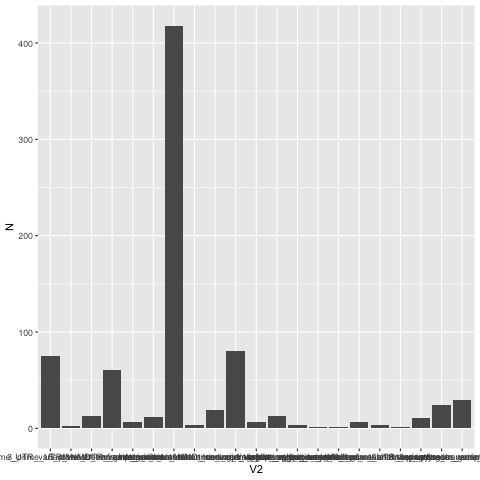

In [8]:
%%R
visData <- vcfData[,.N,by=.(V2)]
p1 <- ggplot(visData, aes(V2, N)) + geom_bar(stat="identity")
p1

Here we call just a very simple ggplot function for a barchart, stat="identity", is telling ggplot to use the actual values in N as the hight of the bars instead of trying to do a count by itself (which is what it does by default). We have a plot now, but it doesn't look very nice. Lets use the fundamental tennet of ggplot and add some layers to improve it. First, the axis scaling makes it hard to read the values of some of the lower data point. Let's correct that now.

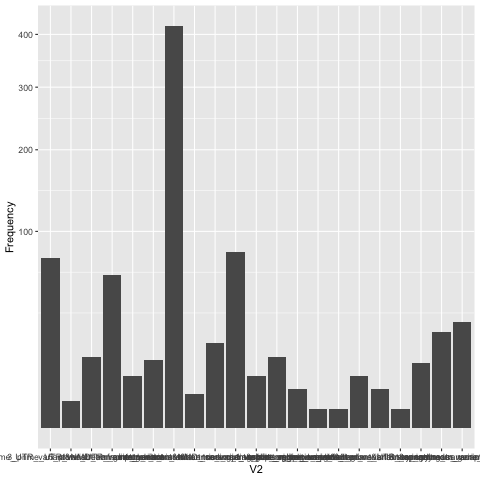

In [9]:
%%R
p1 <- p1 + scale_y_continuous("Frequency",trans="sqrt")
p1

above we transform the y axis to a sqrt scale and rename the axis on the left. next let's fix the x-axis to prevent labels from overlapping, we can do this with theme()

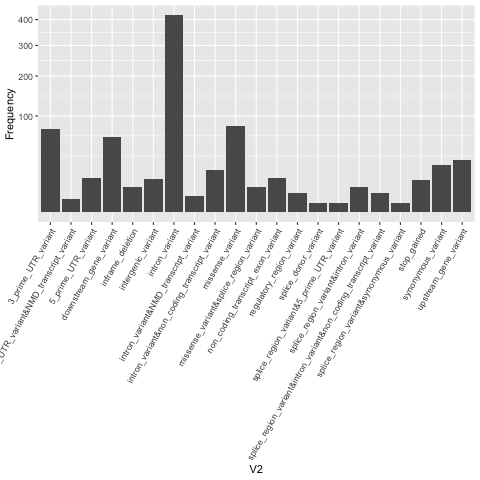

In [10]:
%%R
p1 <- p1 + theme(axis.text.x=element_text(angle=60, hjust=1))
p1

And finally, what if we wanted to annotate on our bars the exact value

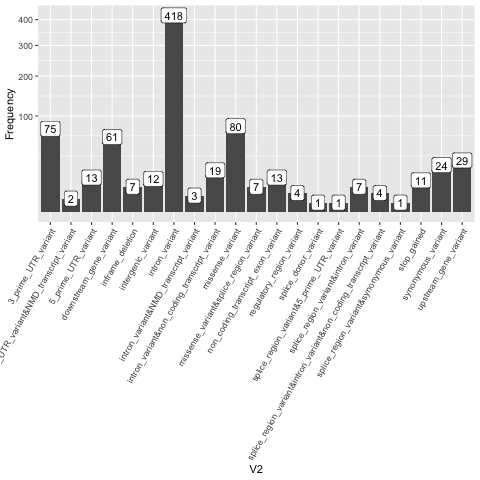

In [11]:
%%R
p1 <- p1 + geom_label(aes(label=N), angle=90)
p1

### Extra resources

- https://genviz.org/module-02-r/0002/03/01/introToggplot2/
- https://genviz.org/module-02-r/0002/02/02/data_munging/
- https://genviz.org/module-02-r/0002/02/01/introductionToR/